In [1]:
import sys
sys.path.append("..")

import numpy as np
from propagation_simulator.environment import environment
from classes.nfpo import NFPO
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

## 環境設定

In [2]:
frequency = 920.4e6
c = 2.998e8
wave_length = c/frequency
sample_count = 100

In [3]:
tag_location= [2,1]
antennas_population = 4
k=-2
antennas_space=0.1

## 位相サンプル生成

In [4]:
env = environment(
    antennas_space=antennas_space,
    antennas_population=antennas_population,
    tag=tag_location,
    frequency=frequency,
    k=k,
    sample_count=sample_count,
)

## 最適化モデル

### 初期値生成

In [5]:
x_list = np.arange(-2,2.1,0.5)
y_list = np.arange(1.0,4.1,0.5)
antennas_population = 4
antennas_space = 0.1

In [6]:
accuracy_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))
solve_time_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))
accuracy_matrix_stepwise = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))
solve_time_matrix_stepwise = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))

for i, x in enumerate(x_list):
    for j, y in enumerate(y_list):
        tag_location = np.array([x,y])
        print("tag_location = " + str(tag_location))
        env = environment(
            antennas_space=antennas_space,
            antennas_population=antennas_population,
            tag=tag_location,
            frequency=frequency,
            k=k,
            sample_count=sample_count,
        )
        _, phases, phases_with_noise = env.get_phases()

        solve_time = 0
        error = 0
        best_initial_value=np.array([0,2])
        min_obj = 1e10
        for grid_x in np.arange(-2,2.0,1.0)+0.5:
            for grid_y in np.arange(1.0,4.0,1.0)+0.5:
                initial_value = np.array([grid_x, grid_y])
                nfpo = NFPO(
                    sample_count=sample_count,
                    antennas_space=antennas_space,
                    phases=phases,
                    antennas_population=antennas_population,
                    wave_length = wave_length,
                    tag_location = tag_location,
                    initial_value = initial_value,
                    range_center = initial_value,
                    y_err_range = 0.6,
                    x_err_range = 0.6,
                    k=k,
                    is_noise_included=True,
                )
                result = nfpo.solve(tee=False, time_limit=30)
                solve_time = solve_time + result["solving_time"]
                # print(f"    initial_value = {initial_value}")
                # print(f"        obj_value = {result["values"]["obj"]}")
                # print(f"        solve_time = {result["solving_time"]}")
                # print(f"        error = {result["values"]["error"]}")
                if min_obj > result["values"]["obj"]:
                    min_obj = result["values"]["obj"]
                    error = result["values"]["error"]
                    best_initial_value = np.array([result["values"]["x"], result["values"]["y"]])
        accuracy_matrix[i][j] = error
        solve_time_matrix[i][j] = solve_time
        print(f"    error = {error}")
        print(f"    solve time = {solve_time}")
        print(f"    best initial value = {best_initial_value}")
        nfpo = NFPO(
            sample_count=sample_count,
            antennas_space=antennas_space,
            phases=phases,
            antennas_population=antennas_population,
            wave_length = wave_length,
            tag_location = tag_location,
            initial_value = best_initial_value,
            y_err_range = 0.1,
            x_err_range = 0.1,
            k=k,
            is_noise_included=True,
        )
        result = nfpo.solve(tee=False, time_limit=10)
        solve_time = solve_time + result["solving_time"]
        error = result["values"]["error"]
        accuracy_matrix_stepwise[i][j] = error
        solve_time_matrix_stepwise[i][j] = solve_time
        print("    error = " + str(error) + "[m], solve time = " + str(solve_time) + "[s]")

tag_location = [-2.  1.]
    error = 0.03968082765100845
    solve time = 44.290000000000006
    best initial value = [-2.00085569  0.9603284 ]
    error = 0.0012542171270921412[m], solve time = 45.00000000000001[s]
tag_location = [-2.   1.5]
    error = 0.020368351513700186
    solve time = 42.66
    best initial value = [-2.00546384  1.48037817]
    error = 0.0004021299683360192[m], solve time = 43.599999999999994[s]
tag_location = [-2.  2.]
    error = 0.015825190622521097
    solve time = 43.61
    best initial value = [-1.99768387  1.98434522]
    error = 0.0001995854863805942[m], solve time = 44.519999999999996[s]
tag_location = [-2.   2.5]
    error = 0.012609203497131936
    solve time = 44.33
    best initial value = [-2.00383893  2.48798939]
    error = 0.0004461991085760823[m], solve time = 45.4[s]
tag_location = [-2.  3.]
    error = 0.013661474602202319
    solve time = 39.57
    best initial value = [-2.00980651  2.99048852]
    error = 0.00031662618226662034[m], solve ti

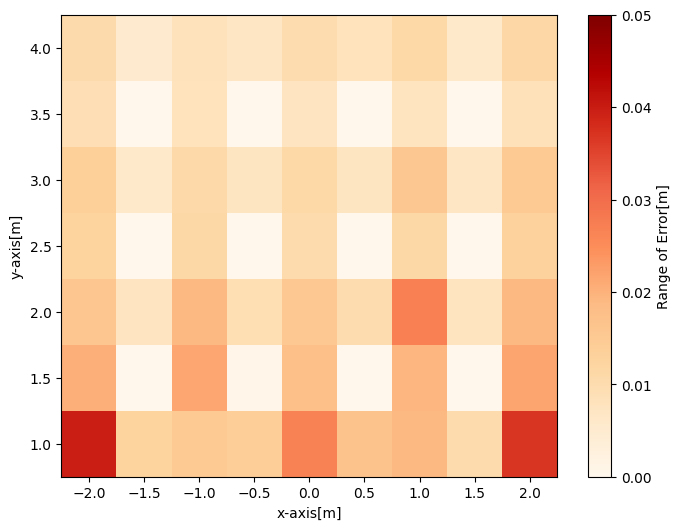

In [7]:
norm1 = Normalize(vmin=0, vmax=0.05)
# norm2 = Normalize(vmin=0, vmax=30)
norm2 = Normalize(vmin=0, vmax=60)
norms = [norm1, norm2]
cb_label = ["Range of Error[m]", "Range of Solve time[s]"]

Y_list, X_list = np.meshgrid(y_list, x_list)

# data = [accuracy_matrix, solve_time_matrix]

# accuracy_mean = accuracy_matrix.mean()
# solve_time_mean = solve_time_matrix.mean()
# print((accuracy_mean,solve_time_mean))

fig,axes = plt.subplots(figsize=(8,6))
mappable=axes.pcolormesh(X_list, Y_list, accuracy_matrix, cmap='OrRd', norm=norm1)
axes.set_xlabel("x-axis[m]")
axes.set_ylabel("y-axis[m]")
cb=fig.colorbar(mappable, ax=axes)
cb.set_label("Range of Error[m]")

In [8]:
np.save("../data/simulation/accuracy_grid.npy", accuracy_matrix)
np.save("../data/simulation/solve_time_grid.npy", solve_time_matrix)
np.save("../data/simulation/accuracy_main2.npy", accuracy_matrix_stepwise)
np.save("../data/simulation/solve_time_main2.npy", solve_time_matrix_stepwise)

In [9]:
# for j, y in enumerate(y_list):
#     if np.round(y, 2) == 2.6:
#         for i, x in enumerate(x_list):
#             x = np.round(x,2)
#             if x == 0.9:
#                 print(accuracy_matrix[i][j])
#                 print(i,j)
#                 accuracy_matrix[i][j] = 0.00024318275687629028
#             if x == 1.0:
#                 print(accuracy_matrix[i][j])
#                 print(i,j)
#                 accuracy_matrix[i][j] = 0.00024318275687629028
#             if x == 1.1:
#                 print(accuracy_matrix[i][j])
#                 print(i,j)
#                 accuracy_matrix[i][j] = 0.00024318275687629028
#             if x == 1.2:
#                 print(accuracy_matrix[i][j])
#                 print(i,j)
#                 accuracy_matrix[i][j] = 0.00024318275687629028

(np.float64(0.011031373807549297), np.float64(36.71222222222223))


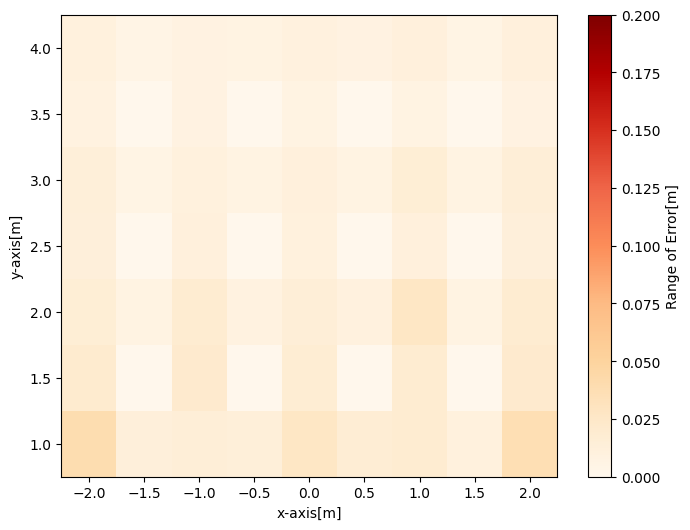

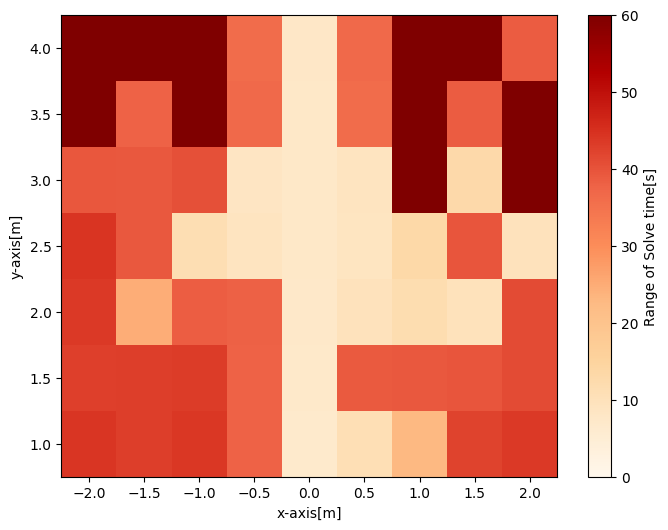

In [10]:
norm1 = Normalize(vmin=0, vmax=0.2)
# norm2 = Normalize(vmin=0, vmax=30)
norm2 = Normalize(vmin=0, vmax=60)
norms = [norm1, norm2]
cb_label = ["Range of Error[m]", "Range of Solve time[s]"]

Y_list, X_list = np.meshgrid(y_list, x_list)

data = [accuracy_matrix, solve_time_matrix]

accuracy_mean = accuracy_matrix.mean()
solve_time_mean = solve_time_matrix.mean()
print((accuracy_mean,solve_time_mean))

for i in np.arange(2):
    fig,axes = plt.subplots(figsize=(8,6))
    mappable=axes.pcolormesh(X_list, Y_list, data[i], cmap='OrRd', norm=norms[i])
    axes.set_xlabel("x-axis[m]")
    axes.set_ylabel("y-axis[m]")
    cb=fig.colorbar(mappable, ax=axes)
    cb.set_label(cb_label[i])

In [11]:
# accuracy_matrix_kt = np.load("../data/simulation/accuracy_kt.npy")
# solve_time_matrix_kt = np.load("../data/simulation/solve_time_kt.npy")
# accuracy_matrix_all = np.load("../data/simulation/accuracy_all.npy")
# solve_time_matrix_all = np.load("../data/simulation/solve_time_all.npy")

datas = [
    [
        accuracy_matrix_kt,
        solve_time_matrix_kt
    ],
    [
        accuracy_matrix_all,
        solve_time_matrix_all
    ],
]


norm1 = Normalize(vmin=0, vmax=0.2)
norm2 = Normalize(vmin=0, vmax=30)
norm3 = Normalize(vmin=0, vmax=60)
norms = [norm1, norm2]
cb_label = ["Range of Error[m]", "Range of Solve time[s]"]

Y_list, X_list = np.meshgrid(y_list, x_list)

for i in range(2):
    for j in range(2):
        fig, ax = plt.subplots(figsize = (5,4))
        mappable = ax.pcolormesh(X_list, Y_list, datas[i][j], cmap='OrRd', norm=norms[j])
        ax.set_xlabel("x-axis[m]")
        ax.set_ylabel("y-axis[m]")
        cb=fig.colorbar(mappable, ax=ax)
        cb.set_label(cb_label[j])
        plt.show() # 図を表示

NameError: name 'accuracy_matrix_kt' is not defined

In [10]:
# x_list = np.arange(-3,4,1)
# y_list = np.ones_like(x_list)
# cor_list = np.vstack([x_list, y_list]).T

# antennas_population_list = np.arange(3,8,1)
# antennas_space_list = np.round(np.arange(0.1, 0.26, 0.01) ,2)

# accuracy_matrix = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))
# solve_time_matrix = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))
# accuracy_matrix_kt = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))
# solve_time_matrix_kt = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))
# accuracy_matrix_all = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))
# solve_time_matrix_all = np.zeros(shape=(cor_list.shape[0], antennas_population_list.shape[0], antennas_space_list.shape[0]))

In [11]:
# for h, cor in enumerate(cor_list):
#     for i, antennas_population in enumerate(antennas_population_list):
#         for j, antennas_space in enumerate(antennas_space_list):
#             env = environment(
#                 antennas_space=antennas_space,
#                 antennas_population=antennas_population,
#                 tag=cor,
#                 frequency=frequency,
#                 k=k,
#                 sample_count=sample_count,
#             )
#             actual_phases, phases, _ = env.get_phases()
#             print(f"antennas_population: {antennas_population}, antennas_space: {antennas_space}, (x,y)={cor}")
#             nfpo_for_init.del_component()
#             nfpo_for_init.renew_parameter(
#                 phases=phases,
#                 antennas_space=antennas_space,
#                 antennas_population=antennas_population,
#                 tag_location=cor,
#                 is_noise_included=False,
#                 initial_value=[0,1],
#                 x_err_range=3,
#                 y_err_range=1,
#             )
#             result = nfpo_for_init.solve(tee=False, time_limit=60)
#             initial_value = np.array([result["values"]["x"], result["values"]["y"]])
#             error = result["values"]["error"]
#             solve_time = result["solving_time"]
#             accuracy_matrix[h][i][j] = error
#             solve_time_matrix[h][i][j] = solve_time
#             print(f"    Phase1 error: {error}, solve_time: {solve_time}")
#             # initial_value = np.array([result["values"]["x"], result["values"]["y"]])
#             # nfpo_for_init.del_component()
#             # nfpo_for_init.renew_parameter(
#             #     is_noise_included=True,
#             #     initial_value=initial_value,
#             #     x_err_range=0.3,
#             #     y_err_range=0.1,
#             # )
#             # result = nfpo_for_init.solve(tee=False, time_limit=60)
#             # print(f"    Phase2 error: {result["values"]["error"]}, solve_time: {result["solving_time"]}")
#             # solve_time = solve_time + result["solving_time"] 
#             # if result["values"]["error"] < error:
#             #     error = result["values"]["error"]
#             # accuracy_matrix_all[h][i][j] = error
#             # solve_time_matrix_all[h][i][j] = solve_time
#             # accuracy_matrix_kt[h][i][j] = result["values"]["error"]
#             # solve_time_matrix_kt[h][i][j] = result["solving_time"]

In [12]:
# np.save("../data/simulation/accuracy_t.npy", accuracy_matrix)
# np.save("../data/simulation/solve_time_t.npy", solve_time_matrix)
# np.save("../data/simulation/accuracy_kt.npy", accuracy_matrix_kt)
# np.save("../data/simulation/solve_time_kt.npy", solve_time_matrix_kt)
# np.save("../data/simulation/accuracy_all.npy", accuracy_matrix_all)
# np.save("../data/simulation/solve_time_all.npy", solve_time_matrix_all)

In [13]:
# accuracy_matrix = np.load("../data/simulation/accuracy_t.npy")
# solve_time_matrix = np.load("../data/simulation/solve_time_t.npy")

# print(np.max(accuracy_matrix))
# norm1 = Normalize(vmin=0, vmax=np.max(accuracy_matrix))
# norm2 = Normalize(vmin=0, vmax=60)
# Antennas_population_list, Antennas_space_list = np.meshgrid(antennas_space_list, antennas_population_list)
# for h,cor in enumerate(cor_list):
#     for i in range(2):
#         fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize = (6,9))
#         if i == 0:
#             ax.plot_surface(Antennas_population_list, Antennas_space_list, accuracy_matrix[h], cmap='bwr', linewidth=1, norm=norm1)
#             ax.set_title(f"Accuraccy for (x,y)={cor}")
#             ax.set_zlabel("Accuracy[m]")
#             ax.set_ylabel("Antenntas population")
#             ax.set_xlabel("Antenntas space[m]")
#             ax.set_zlim(0.0,6.0)
#             ax.set_zticks(np.arange(0.0,6.0,1.0))
#             ax.set_xticks(np.arange(0.1,0.3,0.05))
#             ax.set_yticks(np.arange(3,8,1))
#             fig.subplots_adjust(left=0,top=0.95,bottom=0.01, right=0.8)
#             fig.savefig(f"../../outputs/accuracy{cor}.png", bbox_inches='tight', pad_inches=0.5)
#         if i == 1:
#             ax.plot_surface(Antennas_population_list, Antennas_space_list, solve_time_matrix[h], cmap='bwr', linewidth=1, norm=norm2)
#             ax.set_title(f"Solve time for (x,y)={cor}")
#             ax.set_zlabel("Solve time[m]")
#             ax.set_ylabel("Antenntas population")
#             ax.set_xlabel("Antenntas space[m]")
#             ax.set_zlim(0.0,6.0)
#             ax.set_zticks(np.arange(0.0,70.0,10.0))
#             ax.set_xticks(np.arange(0.1,0.3,0.05))
#             ax.set_yticks(np.arange(3,8,1))
#             fig.subplots_adjust(left=0,top=0.95,bottom=0.01, right=0.9)
#             fig.savefig(f"../../outputs/solve_time{cor}.png", bbox_inches='tight', pad_inches=0.3)